# SJSU MSDS 255 DL, Spring 2024 - Transformers
Homework 10: BERT

Git: https://github.com/jrgosalvez/data255_DL

Source: 
- https://rajpurkar.github.io/SQuAD-explorer
- https://pytorch.org/text/stable/datasets.html#torchtext.datasets.SQuAD2
- https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT/

In [1]:
import torch
import json
import pandas as pd
from transformers import BertTokenizer

In [2]:
# Load pre-trained model tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

## Download the training data

In [3]:
# Define the path to your SQuAD2 data file
squad_data_path = 'train-v2.0.json'

In [4]:
squad_data_path

'train-v2.0.json'

In [5]:
df = pd.read_json(squad_data_path)
df

,version,data
0,v2.0,"{'title': 'Beyoncé', 'paragraphs': [{'qas': [{..."
1,v2.0,"{'title': 'Frédéric_Chopin', 'paragraphs': [{'..."
2,v2.0,{'title': 'Sino-Tibetan_relations_during_the_M...
3,v2.0,"{'title': 'IPod', 'paragraphs': [{'qas': [{'qu..."
4,v2.0,{'title': 'The_Legend_of_Zelda:_Twilight_Princ...
...,...,...
437,v2.0,"{'title': 'Infection', 'paragraphs': [{'qas': ..."
438,v2.0,"{'title': 'Hunting', 'paragraphs': [{'qas': [{..."
439,v2.0,"{'title': 'Kathmandu', 'paragraphs': [{'qas': ..."
440,v2.0,"{'title': 'Myocardial_infarction', 'paragraphs..."


### Open and preprocess (add special tokens) dataset per BERT format

### Load preprocess (add special tokens) the [SQUAD 2.0](https://pytorch.org/text/stable/datasets.html#torchtext.datasets.SQuAD2) dataset per BERT format. Get a minimum 20 QnA pairs. 

In [6]:
# Function to load SQuAD2 data and add special tokens [CLS] and [SEP]
def load_squad_data(file_path, num_samples=20):
    with open(file_path, 'r', encoding='utf-8') as f:
        squad_data = json.load(f)
    
    data = []
    for i in range(min(len(squad_data['data']), num_samples)):
        paragraphs = squad_data['data'][i]['paragraphs']
        for paragraph in paragraphs:
            context = paragraph['context']
            qas = paragraph['qas']
            for qa in qas:
                question = qa['question']
                answers  = qa['answers']
                if answers:  # Check if answers are available
                    answer_text = answers[0]['text']
                    # Tokenize question and answer text .encode automatically adds [CLS] and [SEP]
                    tokenized_question = tokenizer.encode(question, add_special_tokens=True)
                    tokenized_answer = tokenizer.encode(answer_text, add_special_tokens=True)
                    data.append((tokenized_question, tokenized_answer))  
    return data

In [7]:
squad_data = load_squad_data(squad_data_path, num_samples=20)

### Display the first few question-answer pairs

In [8]:
for i in range(8):
    print("Question:", tokenizer.decode(squad_data[i][0]))
    print("Answer:", tokenizer.decode(squad_data[i][1]))
    print()

2024-04-19 06:16:16.717002: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Question: [CLS] when did beyonce start becoming popular? [SEP]
Answer: [CLS] in the late 1990s [SEP]

Question: [CLS] what areas did beyonce compete in when she was growing up? [SEP]
Answer: [CLS] singing and dancing [SEP]

Question: [CLS] when did beyonce leave destiny's child and become a solo singer? [SEP]
Answer: [CLS] 2003 [SEP]

Question: [CLS] in what city and state did beyonce grow up? [SEP]
Answer: [CLS] houston, texas [SEP]

Question: [CLS] in which decade did beyonce become famous? [SEP]
Answer: [CLS] late 1990s [SEP]

Question: [CLS] in what r & b group was she the lead singer? [SEP]
Answer: [CLS] destiny's child [SEP]

Question: [CLS] what album made her a worldwide known artist? [SEP]
Answer: [CLS] dangerously in love [SEP]

Question: [CLS] who managed the destiny's child group? [SEP]
Answer: [CLS] mathew knowles [SEP]



# >> Dataloader tokenizes text automatically <<

### Train and evaluate the BERT QnA model

In [9]:
import torch
from transformers import BertTokenizer, BertForQuestionAnswering, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import squad_convert_examples_to_features
from transformers.data.processors.squad import SquadV2Processor
from tqdm import tqdm
import numpy as np
import random

In [10]:
# Set random seeds for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [11]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer  = BertTokenizer.from_pretrained(model_name)
model      = BertForQuestionAnswering.from_pretrained(model_name)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Define fine-tuning parameters
batch_size = 16
epochs = 20
learning_rate = 3e-5
adam_epsilon = 1e-8

In [13]:
# Load SQuAD 2.0 data and limit to 25 QnA pairs
processor = SquadV2Processor()
train_examples = processor.get_train_examples('./' , filename="train-v2.0.json")[:25]
val_examples   = processor.get_train_examples('./' , filename="train-v2.0.json")[26:37]
test_dataset   = processor.get_train_examples('./' , filename="train-v2.0.json")[38:43]

100%|██████████| 442/442 [00:44<00:00,  9.97it/s]


In [14]:
"""BERT max input sequence length is 512, - 2 for [CLS] and [SEP]; however, 
   sentence-transformers model such as all-mpnet-base-v2 have an input size of 384 tokens.
   so set embeddings texts with 384 tokens (1 token ~= 4 characters ~= 0.75 words)"""

# Convert examples to features
train_features, train_dataset = squad_convert_examples_to_features(
    examples=train_examples,
    tokenizer=tokenizer,
    max_seq_length=384,  # BERT max input length is 512, less 2 for [CLS] and [SEP]
    doc_stride=128,
    max_query_length=64,
    is_training=True,
    return_dataset="pt"
)
val_features, val_dataset = squad_convert_examples_to_features(
    examples=val_examples,
    tokenizer=tokenizer,
    max_seq_length=384,  # BERT max input length is 512, less 2 for [CLS] and [SEP]
    doc_stride=128,
    max_query_length=64,
    is_training=True,
    return_dataset="pt"
)

2024-04-19 06:19:03.749284: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
add example index and unique id: 100%|██████████| 25/25 [00:00<00:00, 59816.09it/s]
2024-04-19 06:19:20.901956: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
add example index and unique id: 100%|██████████| 11/11 [00:00<00:00, 129236.26it/s]


In [15]:
# Create data loader [CLS] & [SEP]
# NOTE: For each batch of the dataloader; input IDs, attention masks, and token type IDs are created, including [CLS] and [SEP]

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader   = DataLoader(val_dataset, sampler=RandomSampler(val_dataset), batch_size=batch_size)
test_dataloader  = DataLoader(test_dataset, sampler=RandomSampler(test_dataset), batch_size=batch_size)

In [16]:
# Prepare optimizer and scheduler
optimizer   = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
total_steps = len(train_dataloader) * epochs
scheduler   = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [17]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Training...")

n_epochs = 0
train_losses, valid_losses = [], []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        inputs = {
            "input_ids": batch[0], # Input token IDs
            "attention_mask": batch[1], # Attention mask
            "token_type_ids": batch[2], # Segment token IDs (for sequence pairs)
            "start_positions": batch[3],# Start position of the answer
            "end_positions": batch[4] # End position of the answer
        }

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch + 1}:')
    print(f'  Average training loss: {avg_train_loss:.4f}')

    # Validation loop
    model.eval()
    total_val_loss = 0
    for step, batch in enumerate(val_dataloader):
        batch = tuple(t.to(device) for t in batch)
        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1],
            "token_type_ids": batch[2],
            "start_positions": batch[3],
            "end_positions": batch[4]
        }

        with torch.no_grad():
            outputs = model(**inputs)
            loss = outputs.loss
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_dataloader)
    valid_losses.append(avg_val_loss)
    print(f'  Average validation loss: {avg_val_loss:.4f}')
    n_epochs += 1

print("Training complete!")

Training...
Epoch 1:
  Average training loss: 5.7485
  Average validation loss: 5.6798
Epoch 2:
  Average training loss: 5.1634
  Average validation loss: 5.4944
Epoch 3:
  Average training loss: 4.7029
  Average validation loss: 5.3331
Epoch 4:
  Average training loss: 4.2855
  Average validation loss: 5.2037
Epoch 5:
  Average training loss: 3.9846
  Average validation loss: 5.1083
Epoch 6:
  Average training loss: 3.6984
  Average validation loss: 5.0379
Epoch 7:
  Average training loss: 3.5189
  Average validation loss: 4.9852
Epoch 8:
  Average training loss: 3.2006
  Average validation loss: 4.9421
Epoch 9:
  Average training loss: 3.1265
  Average validation loss: 4.9121
Epoch 10:
  Average training loss: 2.9589
  Average validation loss: 4.8969
Epoch 11:
  Average training loss: 2.8484
  Average validation loss: 4.8911
Epoch 12:
  Average training loss: 2.7758
  Average validation loss: 4.8919
Epoch 13:
  Average training loss: 2.6153
  Average validation loss: 4.8912
Epoch 14:

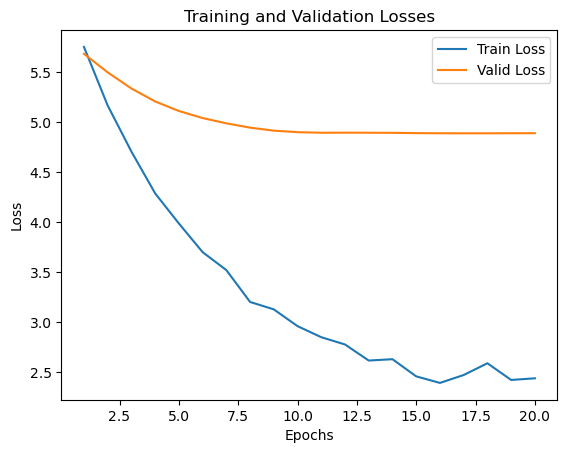

In [18]:
import matplotlib.pyplot as plt
import numpy as np

epoch_ticks = range(1, n_epochs + 1)  # Assuming n_epochs is defined somewhere
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.show()

#### Continual training loss implies potential overfitting

### Perform an Inference and show the predicted vs ground truth answers. 

In [19]:
for example in test_dataset:
    inputs = tokenizer.encode_plus(example.question_text, example.context_text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs['input_ids'].tolist()
    decoded_text = tokenizer.decode(input_ids[0])
    print("DECODED TEXT:", decoded_text)
    print("\nQUESTION:", example.question_text)
    print("CONTEXT:", example.context_text)
    print("ANSWER:", example.answer_text)
    print()
    print()

DECODED TEXT: [CLS] what magazine named beyonce as the most powerful female musician for 2015? [SEP] a self - described " modern - day feminist ", beyonce creates songs that are often characterized by themes of love, relationships, and monogamy, as well as female sexuality and empowerment. on stage, her dynamic, highly choreographed performances have led to critics hailing her as one of the best entertainers in contemporary popular music. throughout a career spanning 19 years, she has sold over 118 million records as a solo artist, and a further 60 million with destiny's child, making her one of the best - selling music artists of all time. she has won 20 grammy awards and is the most nominated woman in the award's history. the recording industry association of america recognized her as the top certified artist in america during the 2000s decade. in 2009, billboard named her the top radio songs artist of the decade, the top female artist of the 2000s and their artist of the millennium 

In [20]:
# Predict a few examples
model.eval()
for example in test_dataset:
    inputs = tokenizer.encode_plus(example.question_text, example.context_text, add_special_tokens=True, return_tensors="pt", max_length=384, truncation=True)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    
    model.to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    start_index = torch.argmax(outputs.start_logits)    # [CLS] start of predicted output
    end_index   = torch.argmax(outputs.end_logits)      # [SEP] stop of predicted output
    
    answer = tokenizer.decode(inputs["input_ids"][0][start_index:end_index+1])

    print("Question:", example.question_text)
    print("Predicted Answer:", answer)
    print("Actual Answer:", example.answer_text)
    print()

Question: What magazine named Beyoncé as the most powerful female musician for 2015?
Predicted Answer: destiny's child
Actual Answer: Forbes

Question: Beyonce's younger sibling also sang with her in what band?
Predicted Answer: houston, texas
Actual Answer: Destiny's Child

Question: Where did Beyonce get her name from?
Predicted Answer: houston, texas
Actual Answer: her mother's maiden name

Question: What race was Beyonce's father?
Predicted Answer: houston, texas
Actual Answer: African-American

Question: Beyonce's childhood home believed in what religion?
Predicted Answer: houston, texas
Actual Answer: Methodist



### Lessons Learned

- 1 token ~= 4 characters ~= 0.75 words
- BERT sequence limit is 512 (less start and stop tokens), so 510
- sentence-transformers model such as all-mpnet-base-v2 have an input size of 384 tokens, make sure to know the model 
- longer input sequence lengths affect context for long-relationship similarity analysis, but more computationaly heavy
- the torch.utils.data dataloader tokenizes text automatically
- for each batch of the dataloader; input IDs, attention masks, and token type IDs are created, including [CLS] and [SEP]
- Training scores in this experiment improve, whereas validation scores improve slightly then flatten implying potential overfitting. To ammend, increase QnA sample size, alter sequence length, or get more data
- Predictions are not accurate for the batch of data trained for the training cycles experimented per results above